# Spanish (Fasttext + BiLSTM + GeLU)

In [2]:
import codecs
import csv
import json
import logging
import os
import re
import sys
import time
from itertools import product

import dill
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
import wandb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
#from simpletransformers.classification import MultiLabelClassificationModel
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
def clean_text(string):
    output = string.strip()
    # replacements = (("“", '"'), ("”", '"'), ("//", ""), ("«", '"'), ("»",'"'))
    replacements = (
      ("“", ''), ("”", ''), ("//", ""), ("«", ''), ("»",''), (",", ''),
      (";", ''), (".", ''),
    #   ("?", ''), ("¿", ''), ("¡", ''), ("!", ''), ("-", ' '),
    )
    for replacement in replacements:
        output = output.replace(*replacement)
    # Any sequence of two or more spaces should be converted into one space
    output = re.sub(r'(?is)\s+', ' ', output)
    return output.strip()


def metric2binary(meter, pad=11):
    return ([1 if syllable == "+" else 0 for syllable in meter] + [0] * (11 - len(meter)))[:pad]


def label2metric(label):
    return "".join("+" if l else "-" for l in label)


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

## Spanish

In [4]:
es_test = (pd
    .read_json(open("adso100.json"))
    .query("manually_checked == True")[["line_text", "metrical_pattern"]]
    .assign(
        line_text=lambda x: x["line_text"].apply(clean_text),
        length=lambda x: x["metrical_pattern"].str.len()
    )
    .drop_duplicates("line_text")
    .rename(columns={"line_text": "text", "metrical_pattern": "meter"})
)
es_test = es_test[es_test["length"] == 11]
pos_names = [f"pos{i}" for i in range(1, 12)]
pos_labels = es_test.meter.apply(metric2binary)
es_test["labels"] = pos_labels
es_test[pos_names] = pos_labels.tolist()
es_test[pos_names] = es_test[pos_names].astype(float)
es = (pd
    .read_json(open("adso.json"))
    .query("manually_checked == True")[["line_text", "metrical_pattern"]]
    .assign(
        line_text=lambda x: x["line_text"].apply(clean_text),
        length=lambda x: x["metrical_pattern"].str.len()
    )
    .drop_duplicates("line_text")
    .rename(columns={"line_text": "text", "metrical_pattern": "meter"})
)
es = es[~es["text"].isin(es_test["text"])][es["length"] == 11]
pos_labels = es.meter.apply(metric2binary)
es["labels"] = pos_labels
es[pos_names] = pos_labels.tolist()
es[pos_names] = es[pos_names].astype(float)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [5]:
es.head()

,text,meter,length,labels,pos1,pos2,pos3,pos4,pos5,pos6,pos7,pos8,pos9,pos10,pos11
112,Cuando la alegre y dulce primavera,---+-+---+-,11,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0]",0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
113,a partir sus riquezas comenzaba,--+--+---+-,11,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]",0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
114,y de los verdes campos desterraba,---+-+---+-,11,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0]",0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
115,aquella estéril sequedad primera,-+-+---+-+-,11,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]",0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
116,un pastor triste y solo en la ribera,+-++-+---+-,11,"[1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]",1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [6]:
es_train, es_val = train_test_split(
    es[["text"] + pos_names], test_size=0.25, random_state=42
)

In [7]:
#!wget http://dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz
#!gunzip glove-sbwc.i25.vec.gz

In [ ]:
#vectors_filename = "glove-sbwc.i25.vec"
#vectors_filename = "SBW-vectors-300-min5.vec"
#vectors_filename = "fasttext-SUC-embeddings-l-model.vec"
vectors_filename = "cc.es.300.vec"

if True: # not os.path.isfile("embeddings_index.pkl"):
    def get_coefs(word, *vector):
        return word, np.asarray(vector, dtype='float32')
    with open(f"/home/jupyter/{vectors_filename}") as vec_file:
        embeddings_index = dict(
            get_coefs(*line.strip().split())
            for idx, line in enumerate(tqdm(vec_file))
            if idx != 0  # First line continas counts
        )
#    with open("embeddings_index.pkl", "wb") as embeddings_file:
#        dill.dump(embeddings_index, embeddings_file)
else:
    with open("embeddings_index.pkl", "rb") as embeddings_file:
        embeddings_index = dill.load(embeddings_file)

1169756it [02:44, 6998.88it/s]

In [ ]:
embed_size = 300  # how big is each word vector
max_features = 7500  # how many unique words to use (i.e num rows in embedding vector)
maxlen = 24  # max number of words per input
y_train = es_train[pos_names].values
y_test = es_test[pos_names].values
y_val = es_val[pos_names].values

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(es_train.text.values))
tokenized_train = tokenizer.texts_to_sequences(es_train.text.values)
tokenized_val = tokenizer.texts_to_sequences(es_val.text.values)
tokenized_test = tokenizer.texts_to_sequences(es_test.text.values)
X_train = pad_sequences(tokenized_train, maxlen=maxlen, padding="post")
X_val = pad_sequences(tokenized_val, maxlen=maxlen, padding="post")
X_test = pad_sequences(tokenized_test, maxlen=maxlen, padding="post")

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

In [ ]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        break
    embedding_vector = embeddings_index.get(word, embeddings_index.get(word.lower()))
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [14]:
inp = Input(shape=maxlen)
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(11, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
print(model.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 24, 300)           2250000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 24, 100)           140400    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 11)               

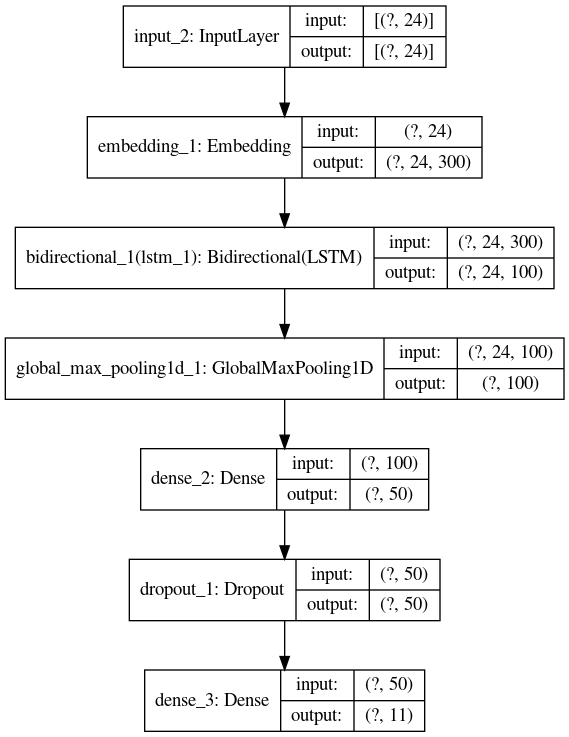

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
es_train.iloc[0].text

'Y cuando fija en el madero tienes'

In [18]:
X_train[0]

array([   3,   53, 3159,    5,    4, 3160, 1138,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [19]:
history10 = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

Epoch 1/10
205/205 [==============================] - 37s 181ms/step - loss: 0.4424 - accuracy: 6.0994e-04 - val_loss: 0.3937 - val_accuracy: 0.0000e+00
Epoch 2/10
205/205 [==============================] - 37s 180ms/step - loss: 0.3754 - accuracy: 0.0000e+00 - val_loss: 0.3630 - val_accuracy: 0.0000e+00
Epoch 3/10
205/205 [==============================] - 36s 178ms/step - loss: 0.3188 - accuracy: 3.0497e-04 - val_loss: 0.3596 - val_accuracy: 0.0000e+00
Epoch 4/10
205/205 [==============================] - 36s 177ms/step - loss: 0.2629 - accuracy: 1.5249e-04 - val_loss: 0.3634 - val_accuracy: 0.0000e+00
Epoch 5/10
205/205 [==============================] - 36s 176ms/step - loss: 0.2201 - accuracy: 0.0011 - val_loss: 0.3799 - val_accuracy: 0.0000e+00
Epoch 6/10
205/205 [==============================] - 36s 177ms/step - loss: 0.1830 - accuracy: 0.0020 - val_loss: 0.4040 - val_accuracy: 0.0000e+00
Epoch 7/10
205/205 [==============================] - 36s 177ms/step - loss: 0.1468 - accu

In [20]:
model.evaluate(X_test, y_test, verbose=1)

44/44 [==============================] - 1s 15ms/step - loss: 0.5350 - accuracy: 0.0086


[0.5350140333175659, 0.008565310388803482]

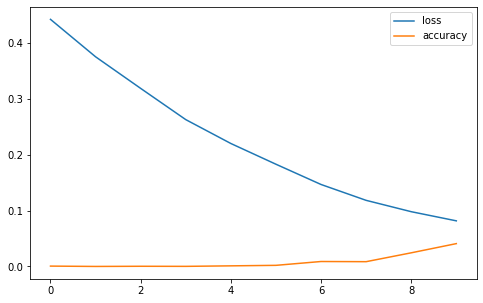

In [28]:
pd.DataFrame(history10.history)[["loss", "accuracy"]].plot(figsize=(8,5))

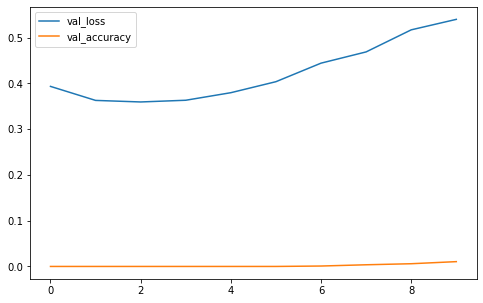

In [29]:
pd.DataFrame(history10.history)[["val_loss", "val_accuracy"]].plot(figsize=(8,5))

In [31]:
history100 = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

Epoch 1/100
205/205 [==============================] - 37s 182ms/step - loss: 0.0408 - accuracy: 0.1045 - val_loss: 0.6898 - val_accuracy: 0.0421
Epoch 2/100
205/205 [==============================] - 37s 178ms/step - loss: 0.0365 - accuracy: 0.1026 - val_loss: 0.7175 - val_accuracy: 0.0444
Epoch 3/100
205/205 [==============================] - 37s 181ms/step - loss: 0.0313 - accuracy: 0.1026 - val_loss: 0.7521 - val_accuracy: 0.0576
Epoch 4/100
205/205 [==============================] - 37s 180ms/step - loss: 0.0270 - accuracy: 0.1224 - val_loss: 0.7980 - val_accuracy: 0.0453
Epoch 5/100
205/205 [==============================] - 37s 180ms/step - loss: 0.0238 - accuracy: 0.1334 - val_loss: 0.8065 - val_accuracy: 0.0873
Epoch 6/100
205/205 [==============================] - 36s 178ms/step - loss: 0.0212 - accuracy: 0.1532 - val_loss: 0.8130 - val_accuracy: 0.1001
Epoch 7/100
205/205 [==============================] - 37s 178ms/step - loss: 0.0192 - accuracy: 0.1468 - val_loss: 0.8776 -

In [32]:
model.evaluate(X_test, y_test, verbose=1)

44/44 [==============================] - 1s 14ms/step - loss: 1.6693 - accuracy: 0.0857


[1.6693007946014404, 0.08565310388803482]

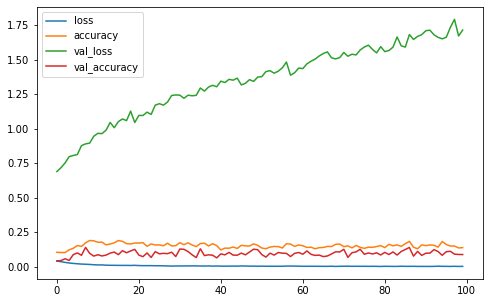

In [33]:
pd.DataFrame(history100.history).plot(figsize=(8,5))

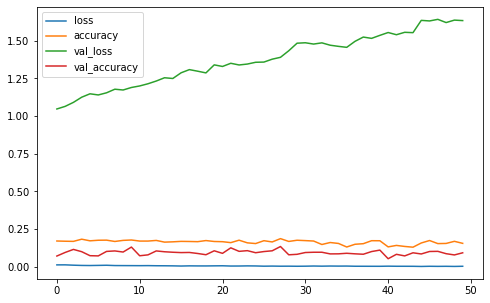

In [103]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

In [107]:
model.save("/home/jupyter/lstm-fasttext.bin")

In [36]:
from tensorflow.compat.v2.keras.utils import multi_gpu_model

In [40]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---

In [34]:
inputs = Input(shape=maxlen)
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inputs)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation=tfa.activations.gelu)(x)
#x = TimeDistributed(Dense(50, activation=tfa.activations.gelu))(x)  # a dense layer as suggested by neuralNer

x = Dropout(0.1)(x)
x = Dense(11, activation="sigmoid")(x)

model_gelu = Model(inputs=inputs, outputs=x)
model_gelu.compile(loss='binary_crossentropy', optimizer=tfa.optimizers.AdamW(weight_decay=1e-4), metrics=['accuracy'])

model_gelu.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 24, 300)           2250000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 24, 100)           140400    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 11)               

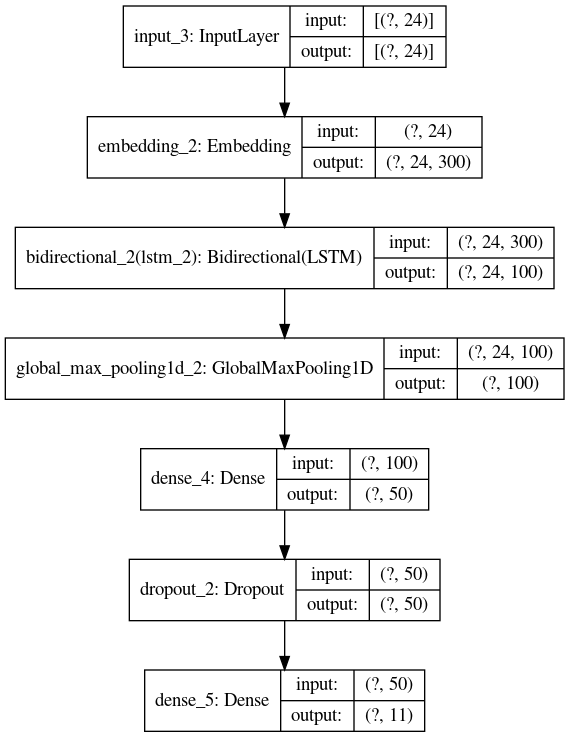

In [35]:
tf.keras.utils.plot_model(model_gelu, show_shapes=True)

In [36]:
history10_gelu = model_gelu.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

Epoch 1/10
205/205 [==============================] - 37s 181ms/step - loss: 0.4386 - accuracy: 0.0011 - val_loss: 0.3942 - val_accuracy: 0.0000e+00
Epoch 2/10
205/205 [==============================] - 37s 178ms/step - loss: 0.3718 - accuracy: 6.0994e-04 - val_loss: 0.3612 - val_accuracy: 0.0032
Epoch 3/10
205/205 [==============================] - 37s 178ms/step - loss: 0.3144 - accuracy: 0.0131 - val_loss: 0.3657 - val_accuracy: 0.0050
Epoch 4/10
205/205 [==============================] - 37s 179ms/step - loss: 0.2542 - accuracy: 0.0203 - val_loss: 0.3804 - val_accuracy: 0.0133
Epoch 5/10
205/205 [==============================] - 37s 180ms/step - loss: 0.2032 - accuracy: 0.0210 - val_loss: 0.3973 - val_accuracy: 0.0119
Epoch 6/10
205/205 [==============================] - 37s 178ms/step - loss: 0.1632 - accuracy: 0.0134 - val_loss: 0.4343 - val_accuracy: 0.0064
Epoch 7/10
205/205 [==============================] - 37s 178ms/step - loss: 0.1306 - accuracy: 0.0212 - val_loss: 0.4677 

In [43]:
model_gelu.evaluate(X_test, y_test, verbose=1)

44/44 [==============================] - 1s 14ms/step - loss: 1.0915 - accuracy: 0.0685


[1.0914541482925415, 0.06852248311042786]

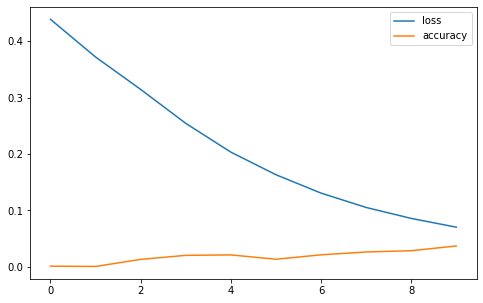

In [38]:
pd.DataFrame(history10_gelu.history)[["loss", "accuracy"]].plot(figsize=(8,5))

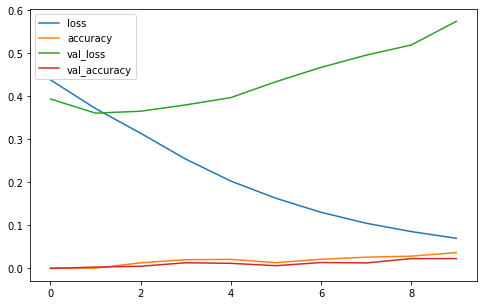

In [42]:
pd.DataFrame(history10_gelu.history).plot(figsize=(8,5))

In [39]:
history100_gelu = model_gelu.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

Epoch 1/100
205/205 [==============================] - 36s 178ms/step - loss: 0.0590 - accuracy: 0.0456 - val_loss: 0.6028 - val_accuracy: 0.0229
Epoch 2/100
205/205 [==============================] - 37s 178ms/step - loss: 0.0483 - accuracy: 0.0453 - val_loss: 0.6132 - val_accuracy: 0.0329
Epoch 3/100
205/205 [==============================] - 37s 181ms/step - loss: 0.0403 - accuracy: 0.0730 - val_loss: 0.6489 - val_accuracy: 0.0517
Epoch 4/100
205/205 [==============================] - 36s 178ms/step - loss: 0.0358 - accuracy: 0.0816 - val_loss: 0.6750 - val_accuracy: 0.0631
Epoch 5/100
205/205 [==============================] - 37s 179ms/step - loss: 0.0310 - accuracy: 0.0990 - val_loss: 0.6752 - val_accuracy: 0.0718
Epoch 6/100
205/205 [==============================] - 37s 179ms/step - loss: 0.0264 - accuracy: 0.1150 - val_loss: 0.7117 - val_accuracy: 0.0617
Epoch 7/100
205/205 [==============================] - 37s 181ms/step - loss: 0.0244 - accuracy: 0.1266 - val_loss: 0.7450 -

In [44]:
model_gelu.evaluate(X_test, y_test, verbose=1)

44/44 [==============================] - 1s 14ms/step - loss: 1.0915 - accuracy: 0.0685


[1.0914541482925415, 0.06852248311042786]

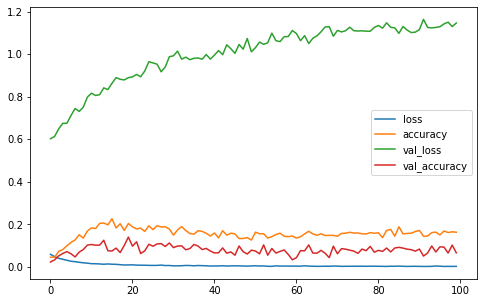

In [41]:
pd.DataFrame(history100_gelu.history).plot(figsize=(8,5))

In [45]:
model_gelu.reset_metrics()
model_gelu.reset_states()

In [46]:
history20_gelu = model_gelu.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

Epoch 1/20
205/205 [==============================] - 35s 169ms/step - loss: 0.0020 - accuracy: 0.1706 - val_loss: 1.1470 - val_accuracy: 0.0466
Epoch 2/20
205/205 [==============================] - 34s 167ms/step - loss: 0.0024 - accuracy: 0.1619 - val_loss: 1.1426 - val_accuracy: 0.0759
Epoch 3/20
205/205 [==============================] - 34s 168ms/step - loss: 0.0020 - accuracy: 0.1642 - val_loss: 1.1551 - val_accuracy: 0.0754
Epoch 4/20
205/205 [==============================] - 35s 168ms/step - loss: 0.0018 - accuracy: 0.1600 - val_loss: 1.2015 - val_accuracy: 0.0768
Epoch 5/20
205/205 [==============================] - 35s 172ms/step - loss: 0.0031 - accuracy: 0.1522 - val_loss: 1.1066 - val_accuracy: 0.0910
Epoch 6/20
205/205 [==============================] - 35s 168ms/step - loss: 0.0022 - accuracy: 0.1654 - val_loss: 1.1641 - val_accuracy: 0.0887
Epoch 7/20
205/205 [==============================] - 34s 168ms/step - loss: 0.0027 - accuracy: 0.1740 - val_loss: 1.1185 - val_ac

In [47]:
model_gelu.evaluate(X_test, y_test, verbose=1)

44/44 [==============================] - 1s 15ms/step - loss: 1.1108 - accuracy: 0.0785


[1.1108118295669556, 0.07851534336805344]

---

In [ ]:
inputs = Input(shape=maxlen)
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inputs)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation=tfa.activations.gelu)(x)
#x = TimeDistributed(Dense(50, activation=tfa.activations.gelu))(x)  # a dense layer as suggested by neuralNer
x = Dropout(0.1)(x)
x = Dense(11, activation="sigmoid")(x)

model_2lstm = Model(inputs=inputs, outputs=x)
model_2lstm.compile(loss='binary_crossentropy', optimizer=tfa.optimizers.AdamW(weight_decay=1e-4), metrics=['accuracy'])

model_2lstm.summary()
tf.keras.utils.plot_model(model_2lstm, show_shapes=True)

In [ ]:
history10_2lstm = model_2lstm.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

In [ ]:
model_2lstm.evaluate(X_test, y_test, verbose=1)

In [ ]:
pd.DataFrame(history10_2lstm.history).plot(figsize=(8,5))

In [ ]:
history100_2lstm = model_2lstm.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

In [ ]:
model_2lstm.evaluate(X_test, y_test, verbose=1)

In [ ]:
pd.DataFrame(history100_2lstm.history).plot(figsize=(8,5))